# Vet a Known Exoplanet
This notebook pulls the parameters and light curve of a known exoplanet, WASP-18 b. It then runs three vetters on on that TCE and light curve. It is used as an example of how to run the vetters in the exovetter package.

In [1]:
import numpy as np
import requests
import matplotlib.pyplot as plt
import pandas as p
from IPython.display import display, HTML

from astropy import units as u
import lightkurve as lk
from exovetter import const as exo_const
from exovetter.model import create_box_model_for_tce
from exovetter.tce import Tce
from exovetter import vetters as vet

%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

planeturl = "https://exo.mast.stsci.edu/api/v0.1/exoplanets/"
header={}

## Create a TCE using exo.MAST requests.
Since we are vetting a known exoplanet, we pull down the information about the exoplanet transit from exo.mast's API. We then create a TCE for vetting. A TCE is an object that contains the transit ephemeris and basic parameters that usually come out of a transit search pipeline (period, epoch, snr, depth).

In [3]:
planet_name = "WASP-18 b"

url = planeturl + "/identifiers/"
myparams = {"name":planet_name}
r = requests.get(url = url, params = myparams, headers = header)
planet_names = r.json()
ticid = planet_names['tessID']
tceid = planet_names['tessTCE']

In [4]:
url = planeturl + planet_name + "/properties/"

r = requests.get(url = url, headers = header)

planet_prop = r.json()
print("Catalog 2: " + planet_prop[1]['catalog_name'])
planet_prop[0].keys()
nexsci_prop = planet_prop[1]  #Second one returned

Catalog 2: nexsci


In [5]:
tce = Tce(period = nexsci_prop['orbital_period'] * u.day,
         epoch = nexsci_prop['transit_time'] * u.day,
         epoch_offset =  -2_400_000.5 * u.day,
         depth = nexsci_prop['transit_depth'] * exo_const.frac_amp,
         duration = nexsci_prop['transit_duration'] * u.day,
         snr = 50, #This value is only used by LPP and doesn't need to be very precise
         event_name = "WASP-18 b",
         target_name = "WASP-18")

# Get a lightkurve for this object
We use the lightkurve package to pull down sector 3 data for TESS data on this object. We then flatten that data to remove any remaining instrumental systematics.

In [6]:
lcf = lk.search_lightcurvefile(tce['target_name'], mission='TESS', sector = 3).download()
lc = lcf.SAP_FLUX.remove_nans().remove_outliers()
flat = lc.flatten(window_length=81)

/var/folders/qd/p48wml6j7313gsggzbjyyj000005fl/T/ipykernel_9672/3606397600.py:1: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  lcf = lk.search_lightcurvefile(tce['target_name'], mission='TESS', sector = 3).download()
/Users/mdallas/miniconda3/envs/exovetter_06_08/lib/python3.11/site-packages/lightkurve/search.py:414: LightkurveWarning: Warning: 8 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/var/folders/qd/p48wml6j7313gsggzbjyyj000005fl/T/ipykernel_9672/3606397600.py:2: LightkurveDeprecationWarning: The SAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.SAP_FLUX.remove_nans().remove_outliers()


In [7]:
(flat['time'][5]-flat['time'][4])*24*60

<TimeDelta object: scale='tdb' format='jd' value=1.9999904753785813>

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

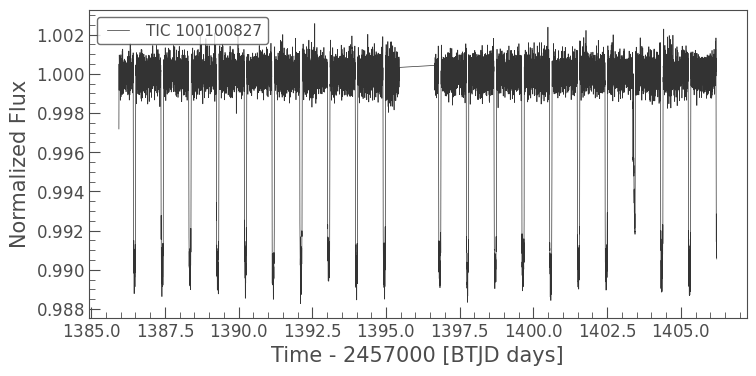

In [8]:
flat.plot()

In [ ]:
lpp = vet.Lpp(lc_name="flux")
_ = lpp.run(tce,flat)

In [ ]:
lpp.plot()

In [ ]:
oe = vet.OddEven()
_ = oe.run(tce,flat)
oe.plot()

In [ ]:
tcover = vet.TransitPhaseCoverage()
_ = tcover.run(tce,flat)
tcover.plot()

In [ ]:
plt.figure()
plt.plot(flat['pdcsap_flux'])
plt.show()

In [ ]:
plt.figure()
plt.plot(flat['time'].value,flat['sap_flux'])
plt.show()

In [ ]:
plt.figure()
plt.plot(flat['flux'])
plt.show()

In [11]:
type(flat['flux_err'].value)

astropy.utils.masked.core.MaskedNDArray

In [33]:
michelle = vet.TessTransitEventStats(raw_name='pdcsap_flux',error_name='flux_err')
michelle.run(tce,flat)

Cadence length not specified, calculated from time array to be: 1.9999904750511632 minutes
Running Metrics
Running Uniqueness Test


({'chases': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.]),
  'rubble': array([1.00294342, 0.97961916, 0.99516867, 0.99516867, 0.94074538,
         0.99516867, 0.99516867, 1.00294342, 0.98739391, 0.93297063,
         0.99516867, 1.00294342, 0.93297063, 1.00294342, 0.95629489,
         0.99516867, 0.98739391, 1.00294342, 1.00294342, 1.00294342,
         0.38096301]),
  'Ntransits': 21,
  'transit_depth': MaskedNDArray(0.00834029),
  'newMES': MaskedNDArray(530.36818007),
  'newNtransits': 20,
  'uni_sig_pri': 532.8987312510671,
  'uni_sig_sec': 1.6053059973822104,
  'uni_sig_ter': 0.8060928763872053,
  'uni_oe_dep': MaskedNDArray(12.71234288),
  'uni_mean_med': 0.975069251984673,
  'uni_shape': 0.0065199852239855435,
  'uni_Fred': 0.37048796499087805,
  'uni_sig_FA1': 4.575813277327469,
  'uni_sig_FA2': 1.6702257749203022,
  'uni_phs_pri': 0.9995653246553983,
  'uni_phs_sec': 0.5017352483795241,
  'uni_phs_ter': 0.7420353470812356,
 

In [34]:
my_version = vet.single_transit_vetter(error_name='flux_err')
my_version.run(tce,flat)

Cadence length not specified, calculated from time array to be: 1.9999904750511632 minutes


{'N_transits': 21,
 'chases': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]),
 'rubble': array([1.00294342, 0.97961916, 0.99516867, 0.99516867, 0.94074538,
        0.99516867, 0.99516867, 1.00294342, 0.98739391, 0.93297063,
        0.99516867, 1.00294342, 0.93297063, 1.00294342, 0.95629489,
        0.99516867, 0.98739391, 1.00294342, 1.00294342, 1.00294342,
        0.38096301])}

In [ ]:
tcover.lc_name

In [ ]:
#Each Vetter can be returned as a dictionary
tcover.__dict__

In [ ]:
#Exovetter uses the lightcurve time_format for units on the times.
lc.time_format